# Autograd: automatic differentiation

The ``autograd`` package provides automatic differentiation for all operations
on Tensors. It is a define-by-run framework, which means that your backprop is
defined by how your code is run, and that every single iteration can be
different.

In [1]:
import torch

Create a tensor:

In [2]:
# Create a 2x2 tensor with gradient-accumulation capabilities
x = torch.tensor([[1, 2], [3, 4]], requires_grad=True, dtype=torch.float32)
print(x)

tensor([[1., 2.],
        [3., 4.]], requires_grad=True)


Do an operation on the tensor:

In [3]:
# Deduct 2 from all elements
y = x - 2
print(y)

tensor([[-1.,  0.],
        [ 1.,  2.]], grad_fn=<SubBackward0>)


``y`` was created as a result of an operation, so it has a ``grad_fn``.



In [4]:
print(y.grad_fn)

In [5]:
# What's happening here?
print(x.grad_fn)

None


In [6]:
# Let's dig further...
y.grad_fn

In [7]:
y.grad_fn.next_functions[0][0]

In [8]:
y.grad_fn.next_functions[0][0].variable

tensor([[1., 2.],
        [3., 4.]], requires_grad=True)

In [9]:
# Do more operations on y
z = y * y * 3
a = z.mean()  # average

print(z)
print(a)

tensor([[ 3.,  0.],
        [ 3., 12.]], grad_fn=<MulBackward0>)
tensor(4.5000, grad_fn=<MeanBackward0>)


In [10]:
# Let's visualise the computational graph! (thks @szagoruyko)
from torchviz import make_dot

In [11]:
# !brew install graphviz

In [12]:
# !echo 'export PATH="/opt/homebrew/opt/openjdk/bin:$PATH"' >> ~/.zshrc
# !echo 'export CPPFLAGS="-I/opt/homebrew/opt/openjdk/include"' >> ~/.zshrc

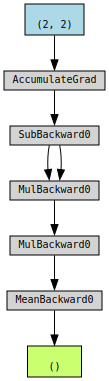

In [13]:
make_dot(a)

## Gradients

Let's backprop now `out.backward()` is equivalent to doing `out.backward(torch.tensor([1.0]))`

In [14]:
_ = y.retain_grad(), z.retain_grad(), a.retain_grad()

In [15]:
# Backprop
a.backward()

Print gradients $\frac{\text{d}a}{\text{d}x}$.




In [16]:
# Compute it by hand BEFORE executing this
print(f'x.grad: {x.grad},\ny.grad: {y.grad},\nz.grad: {z.grad},\na.grad: {a.grad}')

x.grad: tensor([[-1.5000,  0.0000],
        [ 1.5000,  3.0000]]),
y.grad: tensor([[-1.5000,  0.0000],
        [ 1.5000,  3.0000]]),
z.grad: tensor([[0.2500, 0.2500],
        [0.2500, 0.2500]]),
a.grad: 1.0


Observation:

z.grad is [[0.25]*2]*2 because mean is computed as sum(elements)/count(elements) 

You can do many crazy things with autograd!
> With Great *Flexibility* Comes Great Responsibility

In [17]:
# Dynamic graphs!
x = torch.randn(3, requires_grad=True)

y = x * 2
i = 0
while y.data.norm() < 1000:
    y = y * 2
    i += 1
print(y)

tensor([ 684.7039, 1176.0471, 1418.2847], grad_fn=<MulBackward0>)


In [18]:
# If we don't run backward on a scalar we need to specify the grad_output
gradients = torch.FloatTensor([0.1, 1.0, 0.0001])
y.backward(gradients)

print(x.grad)

tensor([1.0240e+02, 1.0240e+03, 1.0240e-01])


In [19]:
# BEFORE executing this, can you tell what would you expect it to print?
print(i)

9


Observation

Grad output means The input dimensions are multiplied by the grad_output and summed up

## Inference

In [20]:
# This variable decides the tensor's range below
n = 3

In [21]:
# Both x and w that allows gradient accumulation
x = torch.arange(1., n + 1, requires_grad=True)
w = torch.ones(n, requires_grad=True)
z = w @ x
z.backward()
print(x.grad, w.grad, sep='\n')

tensor([1., 1., 1.])
tensor([1., 2., 3.])


In [22]:
# Only w that allows gradient accumulation
x = torch.arange(1., n + 1)
w = torch.ones(n, requires_grad=True)
z = w @ x
z.backward()
print(x.grad, w.grad, sep='\n')

None
tensor([1., 2., 3.])


In [23]:
x = torch.arange(1., n + 1)
w = torch.ones(n, requires_grad=True)

# Regardless of what you do in this context, all torch tensors will not have gradient accumulation
with torch.no_grad():
    z = w @ x

try:
    z.backward()  # PyTorch will throw an error here, since z has no grad accum.
except RuntimeError as e:
    print('RuntimeError!!! >:[')
    print(e)

RuntimeError!!! >:[
element 0 of tensors does not require grad and does not have a grad_fn


## More stuff

Documentation of the automatic differentiation package is at
http://pytorch.org/docs/autograd.